# **Model Selection for Prediction of MPG of Cars and Possible Explanatory Variables**

#### Authors: Felix Li, Naaimur Reza, Nitahi Escolar Bach & Yingshan Wu

## Introduction

Canada's climate poses special challenges for fuel-efficient driving. Besides factors such as weather, road conditions
and traffic conditions other more universal factors such as a car's weight, horsepower, and number of cylinders in has
can also affect fuel efficiency. Furthermore, Canada's GHG emmision standards are becoming more strict and with fuel
prices on the rise it's important to learn how and which factors affect the mileage of one's vehicle and be able to
predict the MPG(**Miles Per Gallon**) given external factors. **Our project aims to present all possible linear regression models(in the scope of this class) for predicting MPG and answer which
model is the best.**

For our predictive analysis we have decided to use "Auto MPG Data Set" taken from the StatLib library which is maintained at Carnegie Mellon University. The dataset was used in the 1983 American Statistical Association Exposition. Attributes include city-cycle fuel consumption in miles per gallon, number of cylinders, displacement, horsepower, weight, acceleration, car model year, origin and car name.

Two academic studies that we deemed relevant for this study are: Neelesh A. Patankar, Jane Lin & Tanvee N. Patankar(2021) claimed fuel economy (measured in mpgge) is an absolute measure and tells little about the real mileage efficiency of a car, because efficiency is a relative measure depending on both the input and output and, does not take into account external factors such as road infrastructure and driving conditions. Zoe L., Christine K., Reuven S. & Jonn A. (2021) found that presentation of fuel economy information may increase selection of efficient vehicles.

## Method and Result

The report is trustworthy because it is based on data from a reliable source. The data used it the Auto MPG Data Set which is maintained by a reliable source, Carnegie Mellon University. It will also give insight into fuel efficient cars which are important because of the large amount of emissions cars create.

This report, as mentioned above, will present all possible linear regression models(in the scope of this class) for predicting MPG and answer which model is the best.

Since we have all these correlated variables, we will check the VIF of the input variables and remove variables to get a VIF under 10(we will decide which ones are most appropriate to remove based on existing knowledge on MPG). We choose under 10 because when it is over 10 it is evidence of severe multicollinearity.

From here we will create every combination of model with and without interaction. We will compare these models by running them through 5-fold cross validation and picking the one that achieves the best Mean Squared Error. We are doing cross validation to approximate test Mean Squared Error.

First we load the necessary packages for this data analysis.

In [33]:
# First, we will load required packages
options(repr.plot.width=8, repr.plot.height=6)
library(tidyverse)
library(tidymodels)
library(repr)
library(infer)
library(cowplot)
library(broom)
library(GGally)
library(AER)
library(broom)
library(latex2exp)
library(digest)
library(gridExtra)
library(faraway)
library(mltools)
library(leaps)
library(glmnet)


# Then, set the seed
set.seed(1111)

#### I. Load data from the web

In [34]:
# URL
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"

# Download the dataset from the web
dir.create("data")
destFile <- "data/localfile.data"
download.file(url, destFile)

#### II. Clean and wrangle the data into a tidy format

In [35]:
# Convert from .data file to a dataframe
raw_mpg_data <- read.delim("data/localfile.data", sep= "", header = FALSE)

head(raw_mpg_data)

,V1,V2,V3,V4,V5,V6,V7,V8,V9
,<dbl>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<int>,<chr>
1,18,8,307,130.0,3504,12.0,70,1,chevrolet chevelle malibu
2,15,8,350,165.0,3693,11.5,70,1,buick skylark 320
3,18,8,318,150.0,3436,11.0,70,1,plymouth satellite
4,16,8,304,150.0,3433,12.0,70,1,amc rebel sst
5,17,8,302,140.0,3449,10.5,70,1,ford torino
6,15,8,429,198.0,4341,10.0,70,1,ford galaxie 500


**Explanation**: The raw data is auto-mpg-1.data with 9 columns V1-V9 including data type real number, integer and categorical.

In [36]:
mpg_data_tidy <- raw_mpg_data %>%
        mutate(mpg = V1, cylinders = as.factor(V2), displacement =V3, horsepower = as.integer(V4), 
                    weight = V5, acceleration = V6, model_year = V7, origin = V8) %>%
        select(mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin)


mpg_data <- mpg_data_tidy %>% 
        select(mpg,cylinders,displacement,horsepower,weight,acceleration) %>%
        filter(!is.na(mpg_data_tidy$horsepower)) 


head(mpg_data)
levels(mpg_data$cylinders)
print("Number of rows")
nrow(mpg_data)

Warning message in mask$eval_all_mutate(quo):
"NAs introduced by coercion"


,mpg,cylinders,displacement,horsepower,weight,acceleration
,<dbl>,<fct>,<dbl>,<int>,<dbl>,<dbl>
1,18,8,307,130,3504,12.0
2,15,8,350,165,3693,11.5
3,18,8,318,150,3436,11.0
4,16,8,304,150,3433,12.0
5,17,8,302,140,3449,10.5
6,15,8,429,198,4341,10.0


[1] "3" "4" "5" "6" "8"

[1] "Number of rows"


[1] 392

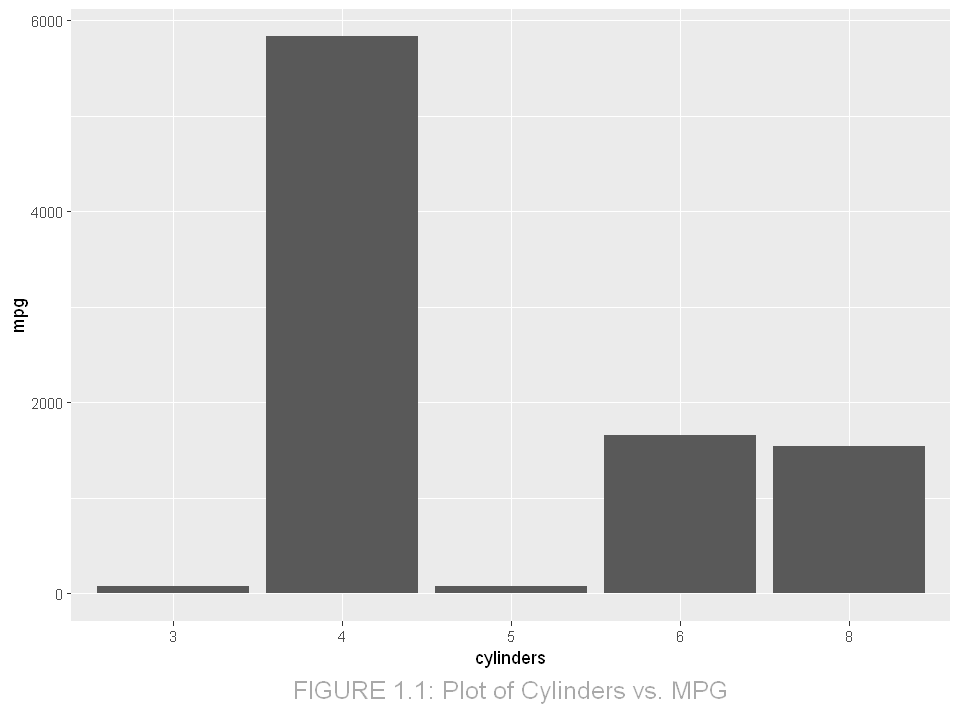

In [37]:
p<-ggplot(data=mpg_data, aes(x=cylinders, y=mpg)) +
  geom_bar(stat="identity")
ggdraw(add_sub(p, "FIGURE 1.1: Plot of Cylinders vs. MPG", 
               size = 15, color = "darkgrey"))


In [38]:
mpg_data <- mpg_data %>%
  mutate(cylinders= ifelse(cylinders == '3',"low",
                             ifelse(cylinders == '4', "low",
                                    ifelse(cylinders == '5', "high",
                                           ifelse(cylinders == '6', "high", 
                                                  ifelse(cylinders == '8', "high",NA)))))) 


head(mpg_data)


,mpg,cylinders,displacement,horsepower,weight,acceleration
,<dbl>,<chr>,<dbl>,<int>,<dbl>,<dbl>
1,18,high,307,130,3504,12.0
2,15,high,350,165,3693,11.5
3,18,high,318,150,3436,11.0
4,16,high,304,150,3433,12.0
5,17,high,302,140,3449,10.5
6,15,high,429,198,4341,10.0


**Explanation**: we rename all the columns to proper names and turn the type of cylinders into factor since it is a categorical 
variable with only 5 levels. And we delete rows with a missing data. Also turn the type of horsepower into integer, and then we 
get rid of column V7,V9 which represents car name, model_year,and origin. car name includes over 100 different strings, and
it makes no sense to turn it into a categorical variable,so we decide to take away this column, for model_year, it is a discrete 
variable which is also over 10 different levels,so we decide to get rid of it to avoid complications. For origin the data does not provide information 
with what 1,2,3 represent so, we won't use this column.

#### III. Plots

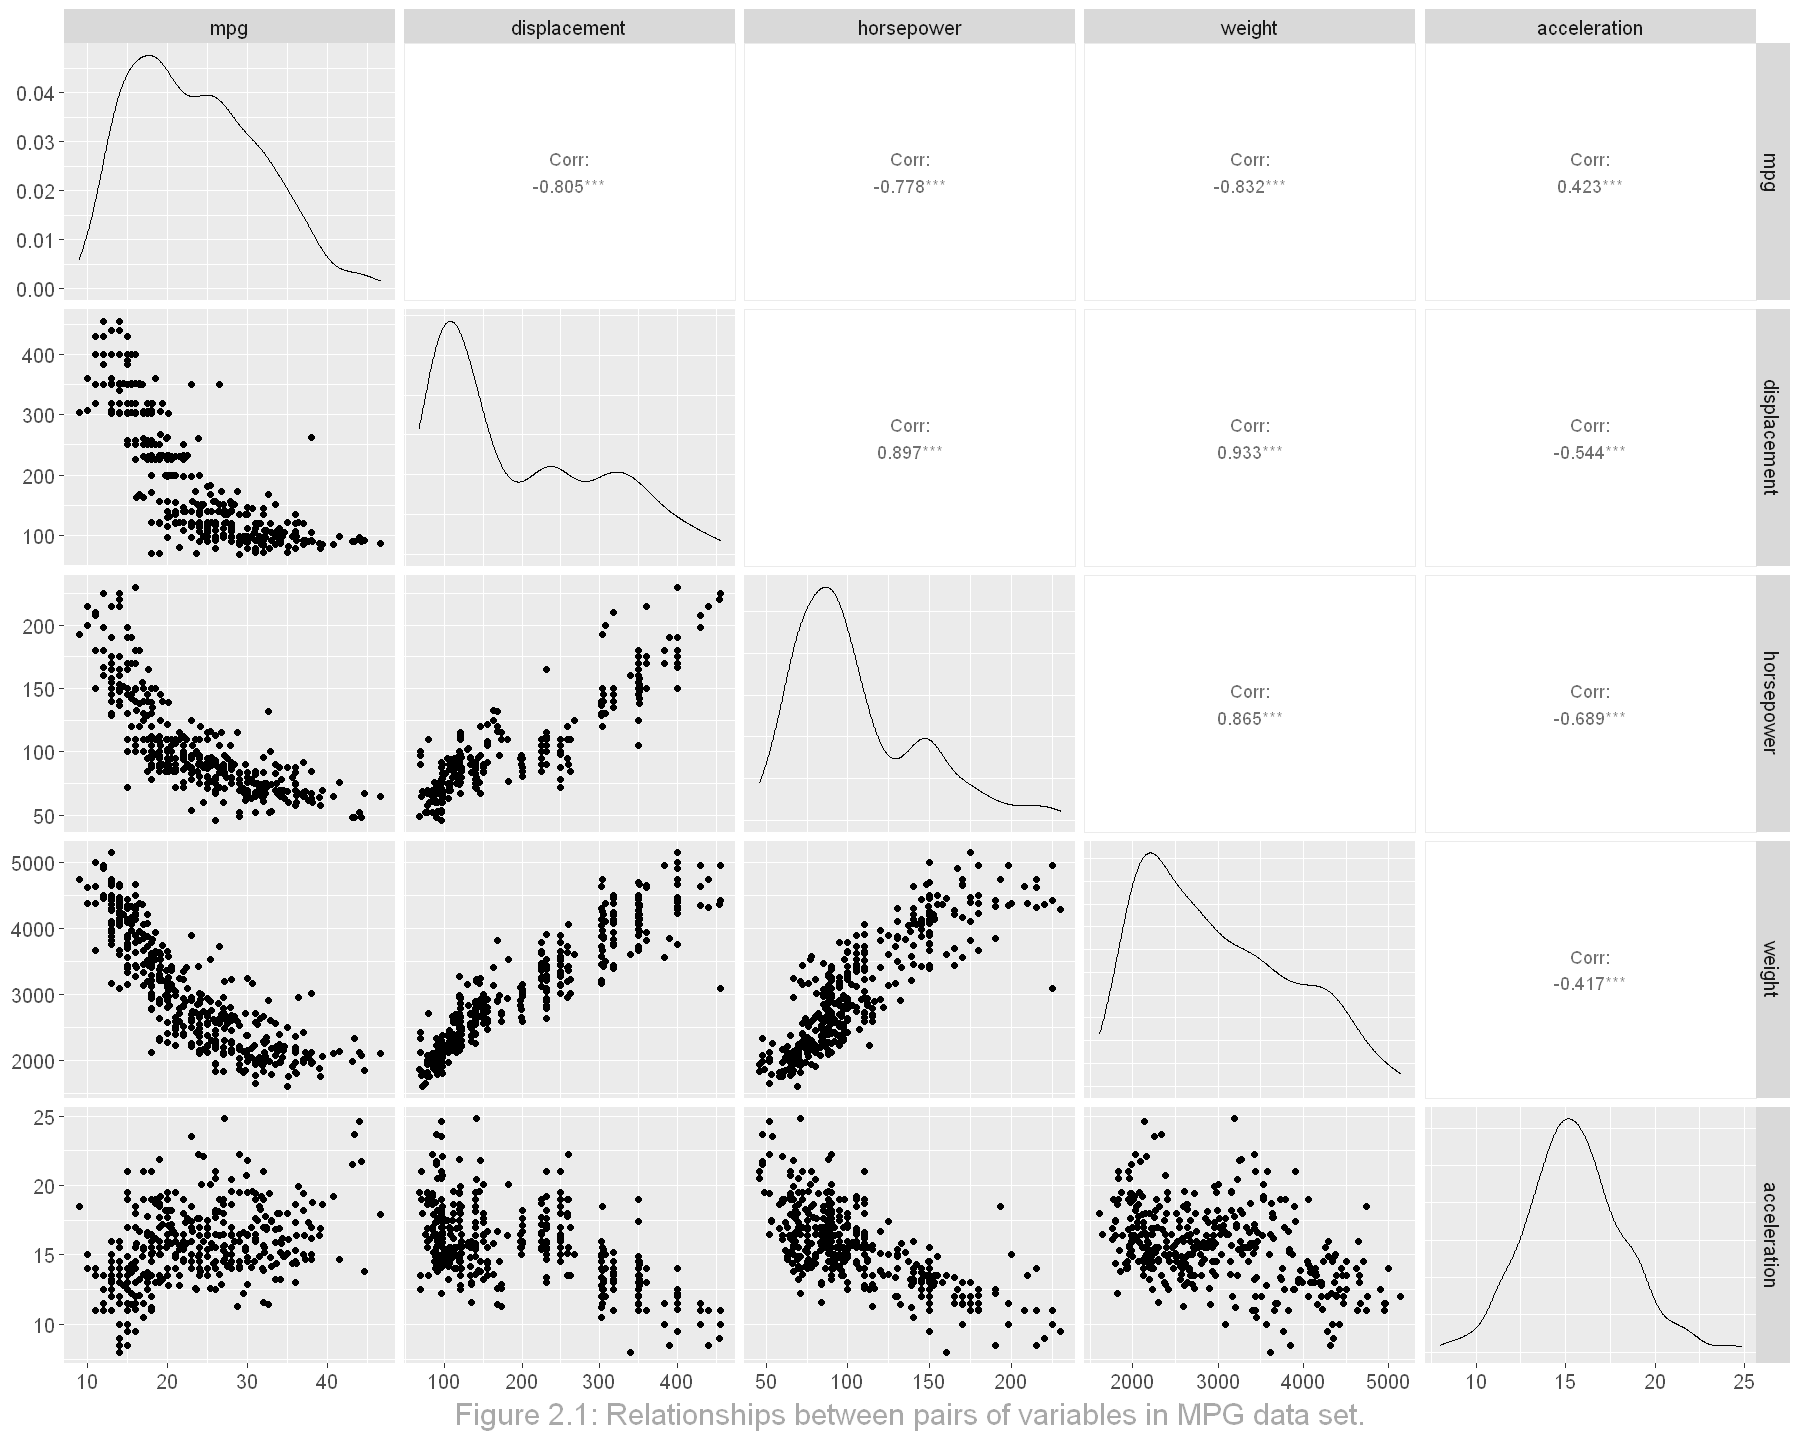

In [39]:
options(repr.plot.width = 15, repr.plot.height = 12)

correlation_plots <- mpg_data %>%
  select(- cylinders) %>%
  ggpairs(progress = FALSE) +
  theme(
    text = element_text(size = 15),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold"),
    plot.caption = element_text(color = "darkgrey", size = 18, hjust = 0.5, vjust = 1)
  ) + 
  labs(caption = "Figure 2.1: Relationships between pairs of variables in MPG data set.")
  
  
correlation_plots

**Explanation**: The correlation plots show the scatterplot of each pair of variables, so that the shape and correlation between variables are clear to see.  Weight and displacement seems to have a very high positive correlation which is 0.933, weight and mpg has a very high negative correlation which is -0.832. The 

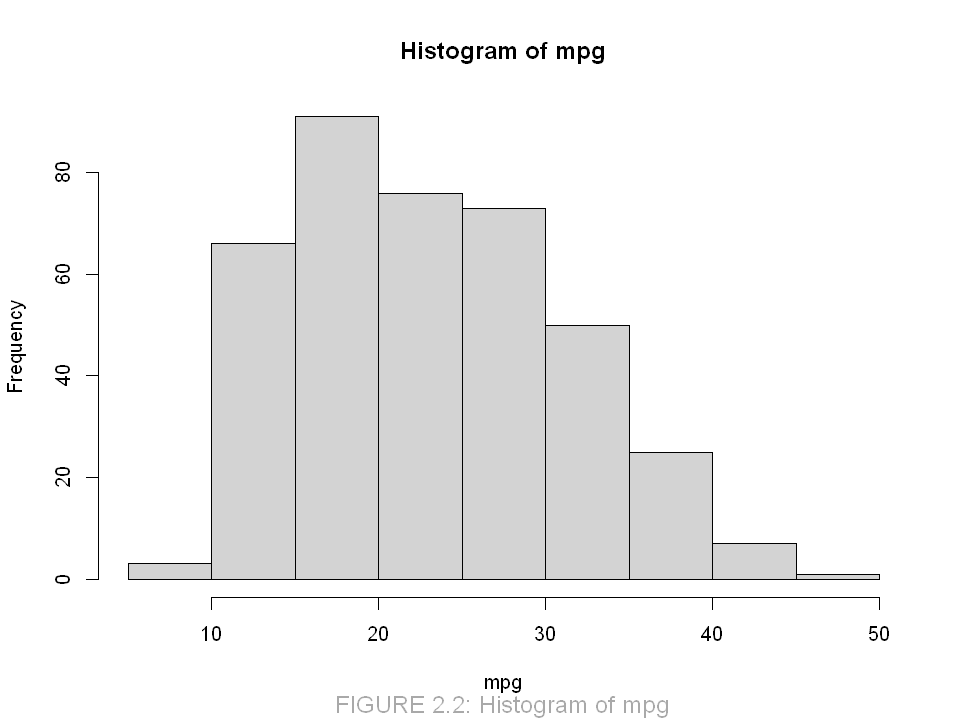

In [11]:
options(repr.plot.width = 8, repr.plot.height = 6)
hist(mpg_data$mpg,
    main="Histogram of mpg",
    xlab="mpg",
    sub = "FIGURE 2.2: Histogram of mpg",
    cex.sub = 1.2,
    col.sub = "darkgrey")

**Explanation**: This histogram shows the distribution of our response variable "mpg", which is "roughly" a normal distibution

In [12]:
summary(mpg_data$mpg)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   9.00   17.00   22.75   23.45   29.00   46.60 

### Dataset Dividing

In [13]:
set.seed(1234)

mpg_data$ID <- 1:nrow(mpg_data)
training_mpg <- sample_n(mpg_data, size = nrow(mpg_data) * 0.60,
  replace = FALSE
)

testing_mpg <- anti_join(mpg_data,
  training_mpg,
  by = "ID"
)



training_mpg <- training_mpg %>% select(-"ID")
testing_mpg <- testing_mpg %>% select(-"ID")

mpg_X_train <- training_mpg %>% select(-"mpg")  %>% data.matrix()
mpg_Y_train <- training_mpg %>% select("mpg")  %>% data.matrix()


mpg_X_test <- testing_mpg %>% select(-"mpg")  %>% data.matrix()
mpg_Y_test <- testing_mpg %>% select("mpg")  %>% data.matrix()


Here we are splitting the data into a training and a test set. We do this to make sure we are testing on new data at the end.

### Forward selection

In [14]:
mpg_forward_sel <- regsubsets(
  x = mpg ~ ., nvmax = 5,
  data = training_mpg,
  method = "forward",
)
    
mpg_forward_summary <- summary(mpg_forward_sel)
mpg_forward_summary

Subset selection object
Call: regsubsets.formula(x = mpg ~ ., nvmax = 5, data = training_mpg, 
    method = "forward", )
8 Variables  (and intercept)
             Forced in Forced out
cylinders4       FALSE      FALSE
cylinders5       FALSE      FALSE
cylinders6       FALSE      FALSE
cylinders8       FALSE      FALSE
displacement     FALSE      FALSE
horsepower       FALSE      FALSE
weight           FALSE      FALSE
acceleration     FALSE      FALSE
1 subsets of each size up to 5
Selection Algorithm: forward
         cylinders4 cylinders5 cylinders6 cylinders8 displacement horsepower
1  ( 1 ) " "        " "        " "        " "        " "          " "       
2  ( 1 ) "*"        " "        " "        " "        " "          " "       
3  ( 1 ) "*"        " "        " "        " "        " "          "*"       
4  ( 1 ) "*"        "*"        " "        " "        " "          "*"       
5  ( 1 ) "*"        "*"        " "        " "        "*"          "*"       
         weight accele

In [15]:
mpg_forward_summary_df <- tibble(
    n_input_variables = 1:5,
    RSQ = mpg_forward_summary$rsq,
    RSS = mpg_forward_summary$rss,
    ADJ.R2 = mpg_forward_summary$adjr2,
    Cp = mpg_forward_summary$cp,
    BIC = mpg_forward_summary$bic,
)
mpg_forward_summary_df

n_input_variables,RSQ,RSS,ADJ.R2,Cp,BIC
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.6806115,4664.264,0.6792407,47.61267,-257.2974
2,0.7074661,4272.086,0.7049443,26.18655,-272.4773
3,0.7229292,4046.268,0.7193309,14.69761,-279.7800
4,0.7295746,3949.220,0.7248716,10.90061,-280.0254
5,0.7374277,3834.535,0.7316947,6.05006,-281.4913


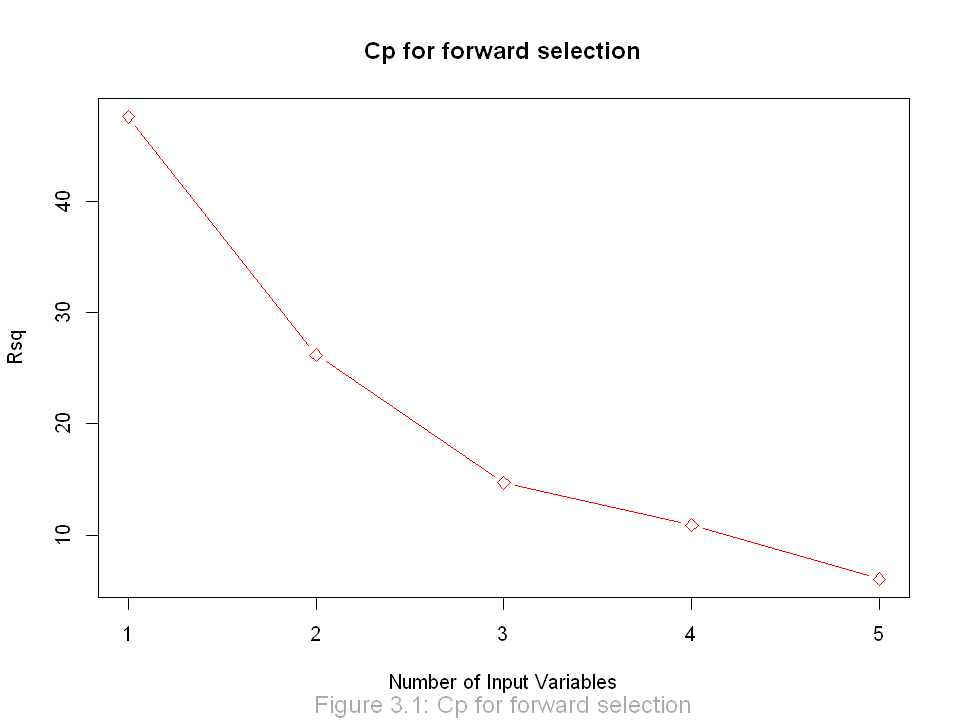

In [20]:
plot(summary(mpg_forward_sel)$cp,
  main = "Cp for forward selection",
  xlab = "Number of Input Variables", ylab = "Rsq", type = "b", pch = 5,
   col = "red", sub = "Figure 3.1: Cp for forward selection", col.sub = "darkgrey", cex.sub = 1.2
)

In [17]:
summary(mpg_forward_sel)

Subset selection object
Call: regsubsets.formula(x = mpg ~ ., nvmax = 5, data = training_mpg, 
    method = "forward", )
8 Variables  (and intercept)
             Forced in Forced out
cylinders4       FALSE      FALSE
cylinders5       FALSE      FALSE
cylinders6       FALSE      FALSE
cylinders8       FALSE      FALSE
displacement     FALSE      FALSE
horsepower       FALSE      FALSE
weight           FALSE      FALSE
acceleration     FALSE      FALSE
1 subsets of each size up to 5
Selection Algorithm: forward
         cylinders4 cylinders5 cylinders6 cylinders8 displacement horsepower
1  ( 1 ) " "        " "        " "        " "        " "          " "       
2  ( 1 ) "*"        " "        " "        " "        " "          " "       
3  ( 1 ) "*"        " "        " "        " "        " "          "*"       
4  ( 1 ) "*"        "*"        " "        " "        " "          "*"       
5  ( 1 ) "*"        "*"        " "        " "        "*"          "*"       
         weight accele

In [18]:
MPG_Selection_OLS <- lm(mpg ~ cylinders+displacement+horsepower+weight,
data = training_mpg
)

Since we are creating a predictive model we choose the model with the lowest $C_p$

The forward selection algorithm with 4 variables chose cylinders, displacement, horsepower, weight. It left out acceleration.

This will be tested along with the other models later in this report.

### Lasso and Ridge Regression

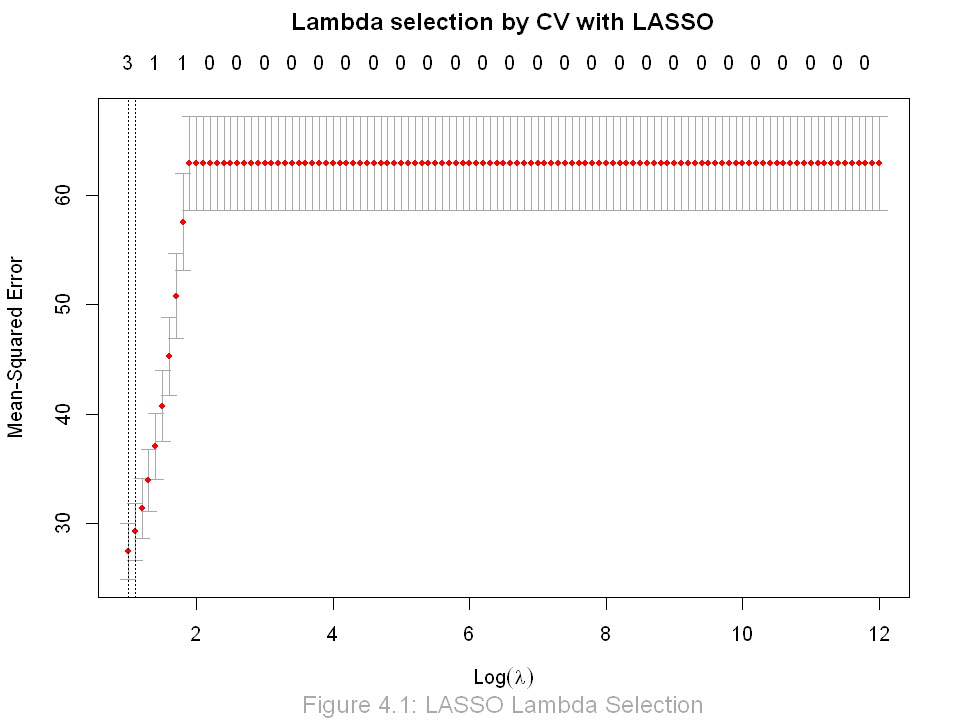

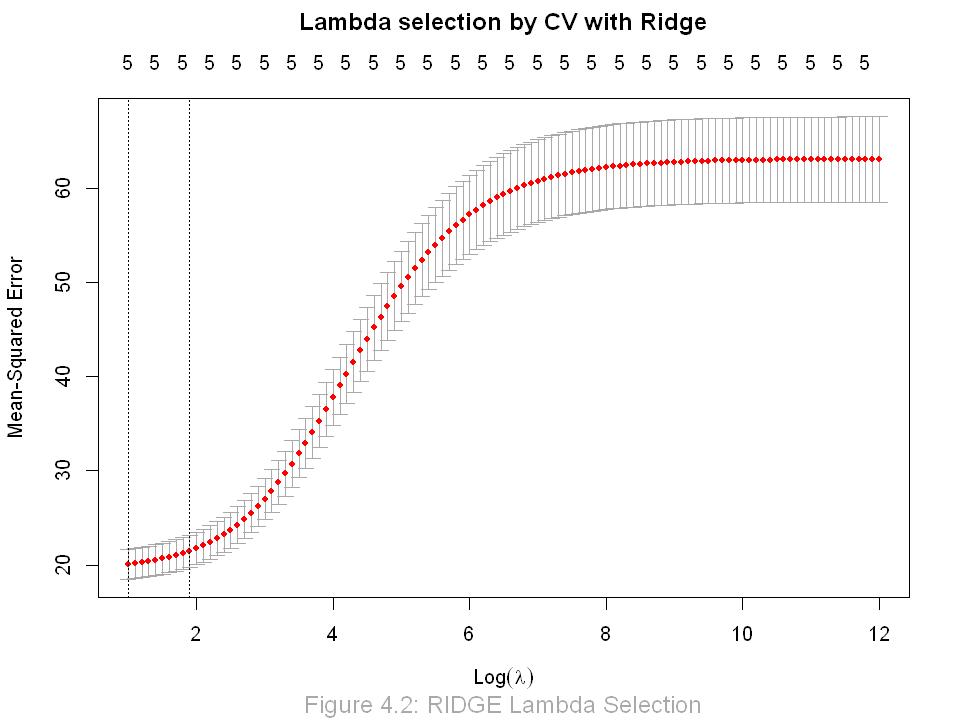

In [21]:
mpg_cv_lambda_LASSO <- cv.glmnet(
  x = mpg_X_train, y = mpg_Y_train,
  alpha = 1,
  lambda = exp(seq(1, 12, 0.1))
)

mpg_cv_lambda_RIDGE <- cv.glmnet(
  x = mpg_X_train, y = mpg_Y_train,
  alpha = 0,
  lambda = exp(seq(1, 12, 0.1))
)

plot(mpg_cv_lambda_LASSO, main = "Lambda selection by CV with LASSO\n\n",
sub = "Figure 4.1: LASSO Lambda Selection", col.sub = "darkgrey", cex.sub = 1.2)
plot(mpg_cv_lambda_RIDGE, main = "Lambda selection by CV with Ridge\n\n",
sub = "Figure 4.2: RIDGE Lambda Selection", col.sub = "darkgrey", cex.sub = 1.2)

We will use the lambda that minimizes MSE in both of these. We choose this because we want our model to be as accurate as possible. For the LASSO model using the biggest lambda 1 standard error away also chooses 3 variables so it seems better to pick the minimum.

In [23]:
mpg_lambda_LASSO <- glmnet(
  x = mpg_X_train, y = mpg_Y_train,
  alpha = 1,
  lambda = mpg_cv_lambda_LASSO$lambda.min
)

mpg_lambda_RIDGE <- glmnet(
  x = mpg_X_train, y = mpg_Y_train,
  alpha = 0,
  lambda = mpg_cv_lambda_RIDGE$lambda.min
)

This creates the models with the minimum lambda

## Testing

We will compare OLS, forward selection OLS, Lasso Regression, and Ridge Regression

In [24]:
MPG_Full_OLS <- lm(mpg ~ .,
data = training_mpg
)

mpg_lambda_LASSO.coef <- mpg_lambda_LASSO$beta
mpg_lambda_RIDGE.coef <- mpg_lambda_RIDGE$beta
MPG_coef <- round(cbind(
  Full_OLS = coef(MPG_Full_OLS),
  Selection_OLS = coef(MPG_Selection_OLS),
  LASSO_min = c(
    mpg_lambda_LASSO$a0,
    as.vector(mpg_lambda_LASSO.coef)
  ),
  RIDGE_min = c(
    mpg_lambda_RIDGE$a0,
    as.vector(mpg_lambda_RIDGE.coef)
  )

), 4)
MPG_coef

Warning message in cbind(Full_OLS = coef(MPG_Full_OLS), Selection_OLS = coef(MPG_Selection_OLS), :
"number of rows of result is not a multiple of vector length (arg 2)"


,Full_OLS,Selection_OLS,LASSO_min,RIDGE_min
(Intercept),39.1809,36.3943,35.9054,40.2535
cylinders4,7.6954,7.1489,-0.1571,-1.0871
cylinders5,9.3734,8.8669,0.0000,-0.0109
cylinders6,2.1990,1.7132,-0.0158,-0.0426
cylinders8,3.4375,2.9995,-0.0034,-0.0022
displacement,0.0138,0.0175,0.0000,-0.0145
horsepower,-0.0838,-0.0660,35.9054,40.2535
weight,-0.0039,-0.0048,-0.1571,-1.0871
acceleration,-0.2204,36.3943,0.0000,-0.0109


These are the coefficients for each model. We can see that LASSO has some variables set to 0, that is because LASSO is able to do variable selection.

the regularized models tend to have smaller coefficients with LASSO having the smallest.

Something to note is that it seems like Selection_OLS has acceleration as a coefficient, that is not true, it is a consequences of putting them all into the same table. The real model doesn't have acceleration selected.

In [25]:
MPG_test_pred_full_OLS <- predict(MPG_Full_OLS, newdata = testing_mpg)

MPG_test_pred_selection_OLS <- predict(MPG_Selection_OLS, newdata = testing_mpg)

MPG_test_pred_LASSO <- predict(mpg_lambda_LASSO,
  newx = mpg_X_test)

MPG_test_pred_RIDGE <- predict(mpg_lambda_RIDGE,
  newx = mpg_X_test)

Here we are predicting on each model

In [26]:
mpg_RMSE_models <- rbind(tibble(
  Model = "OLS Full Regression",
  R_MSE = rmse(
    preds = MPG_test_pred_full_OLS,
    actuals = testing_mpg$mpg
  )
),tibble(
  Model = "OLS Selection Regression",
  R_MSE = rmse(
    preds = MPG_test_pred_selection_OLS,
    actuals = testing_mpg$mpg
  )
),
    tibble(
    Model = "LASSO Regression with minimum MSE",
    R_MSE = rmse(
      preds = MPG_test_pred_LASSO,
      actuals = testing_mpg$mpg
    ),
  ),
  tibble(
    Model = "RIDGE Regression with minimum MSE",
    R_MSE = rmse(
      preds = MPG_test_pred_RIDGE,
      actuals = testing_mpg$mpg
    )
  )
)
mpg_RMSE_models

Model,R_MSE
<chr>,<dbl>
OLS Full Regression,3.967519
OLS Selection Regression,3.933406
LASSO Regression with minimum MSE,5.060230
RIDGE Regression with minimum MSE,4.183918


From this we see that OLS with Selection performed the best because it has the lowest RMSE. Full OLS almost does as well, with RIDGE being third and LASSO doing the worse.

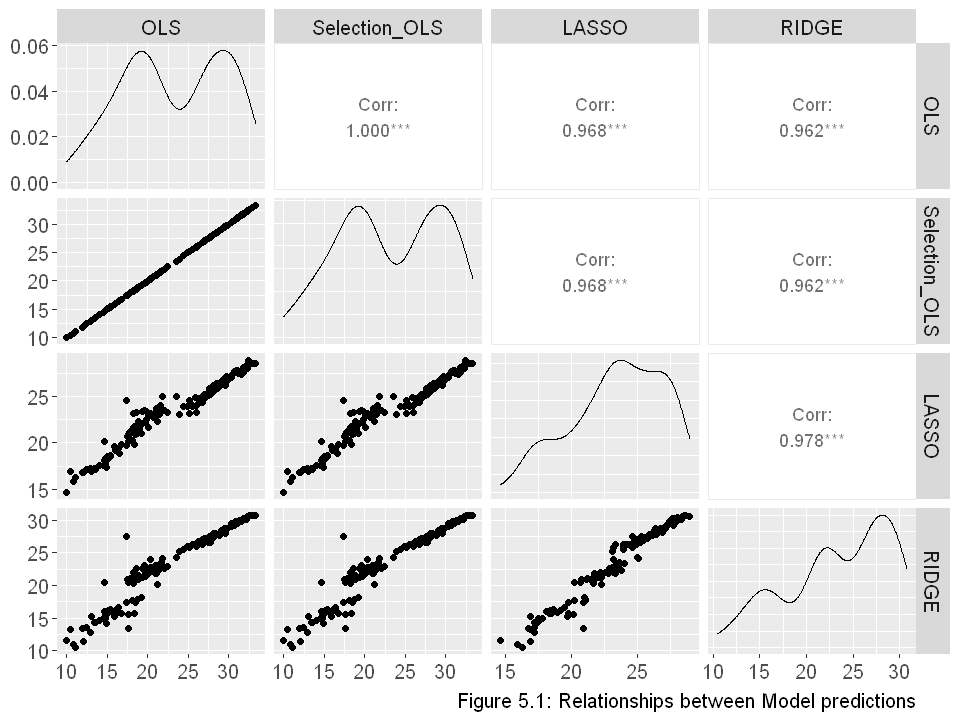

In [27]:
pred_data = tibble(OLS = MPG_test_pred_selection_OLS,Selection_OLS = MPG_test_pred_selection_OLS,LASSO = as.vector(MPG_test_pred_LASSO), RIDGE = as.vector(MPG_test_pred_RIDGE))
correlation_plots <- pred_data %>%
  ggpairs() +
  theme(
    text = element_text(size = 15),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold")
  )+
  labs(caption = "Figure 5.1: Relationships between Model predictions")
correlation_plots

This plot helps quantify the difference between the models. All the models end up with similar predictions. While selection OLS does the best, the other models aren't too far behind.


## Discussion


We found out that the most important variables selected with forward selection which ended up having the best test error are cylinders, displacement, horsepower, weight.
We were able to relatively accurately predict the MPG of a vehicle based on the low test error our model produced. This implies that consumers could have a pretty accurate idea of how efficient a vehicle would be before having experience with it.
For consumers when choosing a vehicle, one can put the necessary data into the model and it will give an estimated MPG. This is specifically useful for people who are restricted by emission limits or are experiencing financial hardships due to rising fuel prices.


We expected to get a relatively accurate measure but we would have expected our prediction to be less accurate. There are many factors that aren't in the dataset which we expected to have an effect and cause more variation in the data. A factor like the amount of years a car has been driven, or how often it gets maintentance.


While the variables used in this model are only related to a vehicle itself, other external factors that are not included in our study such as weather, road conditions, traffic conditions, etc would also impact MPG. The dataset is also a bit dated, having more modern data would give better insight for consumers in the current day.


Our study could provide insight for future exploration of these possible external factors. In places where there is more traffic or more extreme weather, car performance will likely differ. Different car factors will likely change the MPG based on different environments. 
A further study building models based on external environmental factors could also help consumers choosing a fuel efficient vehicle fit for their use and environment.

## References

Neelesh A. Patankar, Jane Lin & Tanvee N. Patankar(October, 2021), <em>Mileage efficiency of cars</em>, vol. 4, ScienceDirect. Retrieved November 3, 2022 from https://www.sciencedirect.com/science/article/pii/S2666790821002007#

Zoe Long, Christine Kormos, Reuven Sussman & Jonn Axsena (April, 2021), <em>MPG, fuel costs, or savings? 
Exploring the role of information framing in consumer valuation of fuel economy using a choice experiment</em>, vol 146, ScienceDirect. Retrieved November 3, 2022 from https://www.sciencedirect.com/science/article/pii/S096585642100032X#